# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Chargement des datasets 

### Chargement du fichier contenant les 'labels' + 'image path'

In [3]:
df= pd.read_csv("projet_6_fichier_pathway_avant_modelisation_images.csv")
data=df.copy()
data.head()

id   
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                          image_path  label_name  label  
0  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
1  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
2  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
3  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
4  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4

In [4]:
data.groupby("label").count()

id  image_path  label_name
label                             
0      150         150         150
1      150         150         150
2      150         150         150
3      150         150         150
4      150         150         150
5      150         150         150
6      150         150         150

In [5]:
data.label_name.unique()

array(['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers'], dtype=object)

# Chargement et traitement des images

In [5]:
import cv2
from matplotlib.image import imread


def pretraitement_image(image_name):
    path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
    filename = path + image_name
    image = imread(filename)

    sift = cv2.SIFT_create(200)
    image = cv2.imread(filename)

    plt.figure(figsize=(20, 13))

    plt.subplot(2,3,1)
    plt.axis('off')
    plt.title('Image Originale')
    plt.imshow(image)

    plt.subplot(2,3,2)
    
    #Supprimer le bruit
    image = cv2.GaussianBlur(image, (5, 5), 0)
    plt.axis('off')
    plt.title('Image débruitée')
    plt.imshow(image)

    # noir et blanc
    plt.subplot(2,3,3)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    plt.title('Noir et blanc')
    plt.imshow(gray_img,cmap='gray')

    #Augmentation du contraste par égalisation du contraste
    plt.subplot(2,3,4)
    image = cv2.equalizeHist(gray_img)   # equalize image histogram
    plt.axis('off')
    plt.title('Rajout contraste')
    plt.imshow(image, cmap='gray')

    #on redimensionne pour normaliser entrée
    plt.subplot(2,3,5)
    dsize = (224, 224)
    image = cv2.resize(image, dsize)
    plt.axis('off')
    plt.title('Redimensionnement')
    plt.imshow(image, cmap='gray')

    #detecion feature SIFT
    plt.subplot(2,3,6)

    kp, des = sift.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image,kp,gray_img)
    plt.axis('off')
    plt.title('features SIFT')
    plt.imshow(img)
    plt.show()

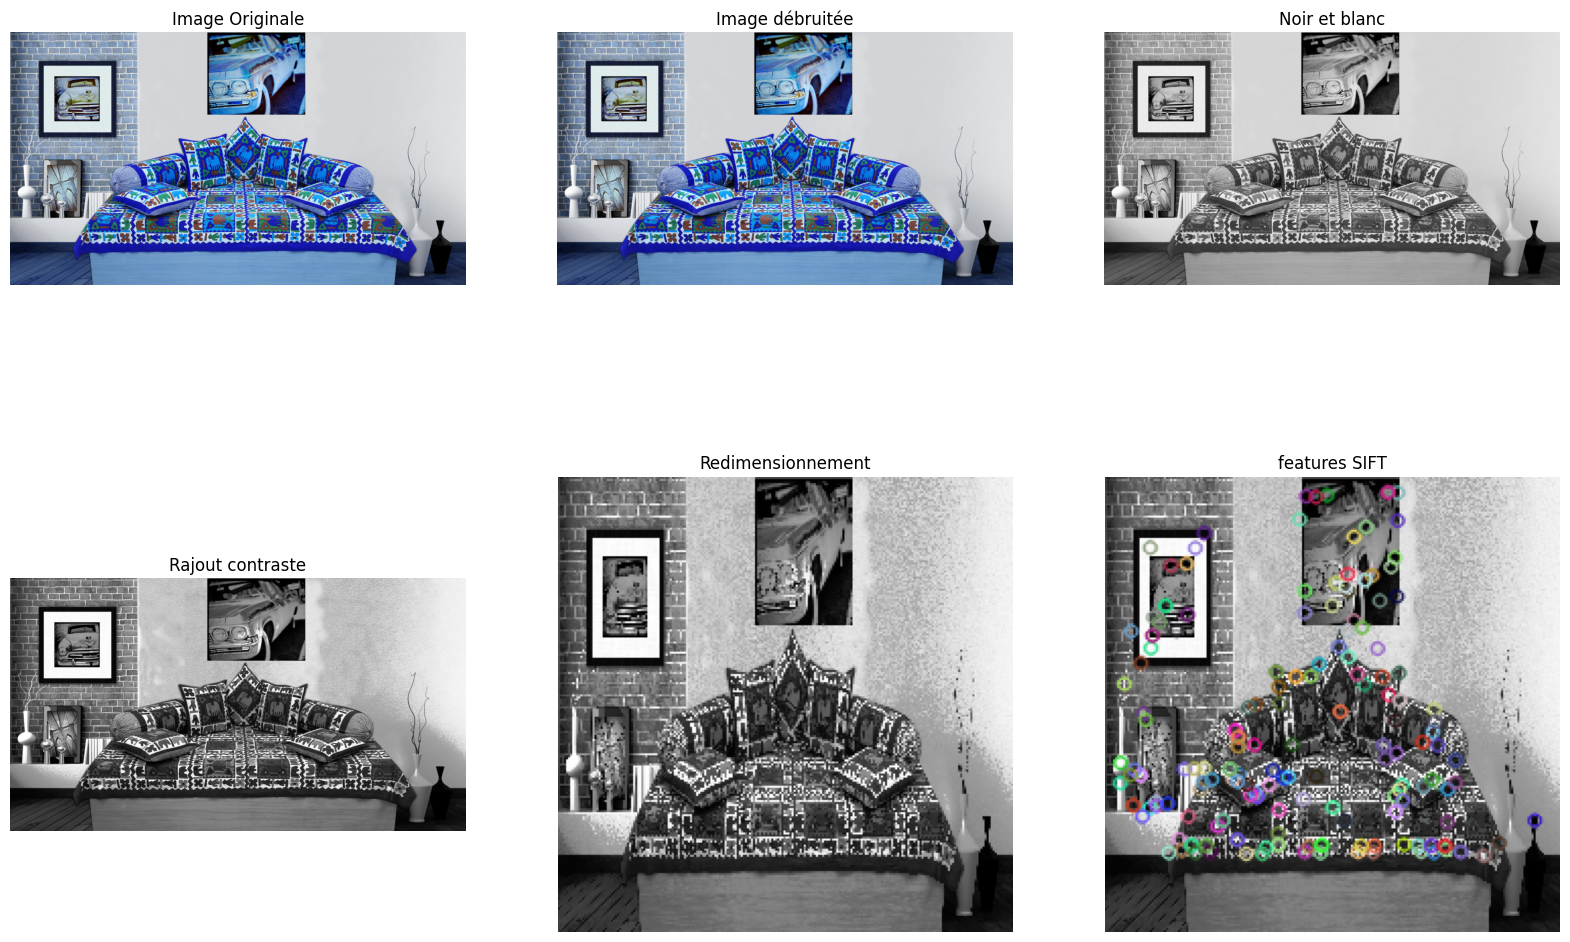

In [6]:
pretraitement_image('0a8a1e9c6659361c0c2b247f8a6471d0.jpg')

Furnishing


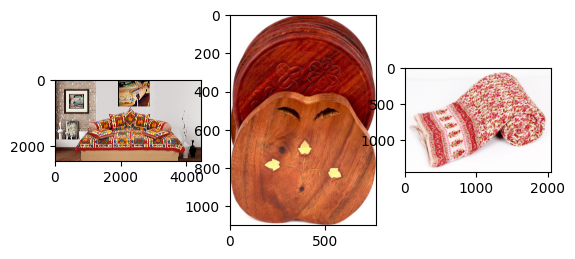

Baby


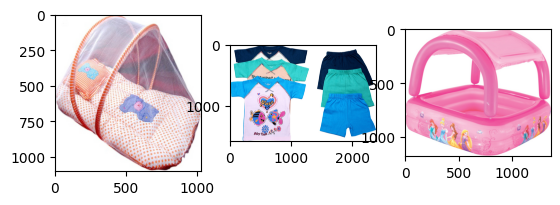

Watches


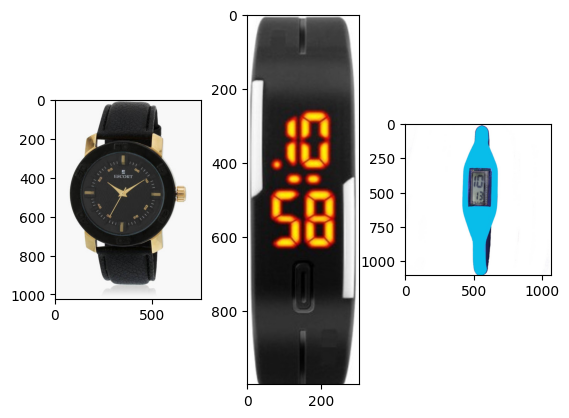

Decor


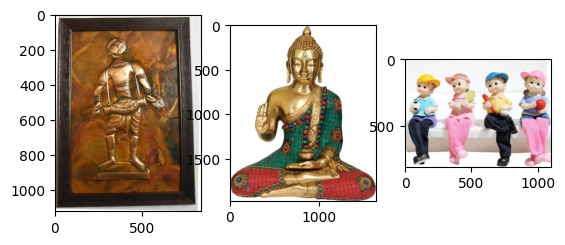

Kitchen


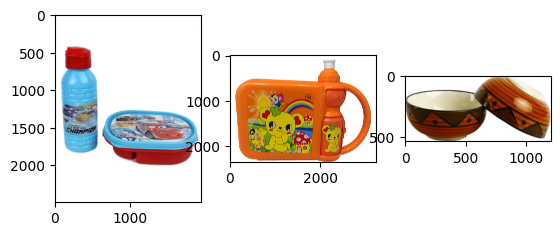

Beauty


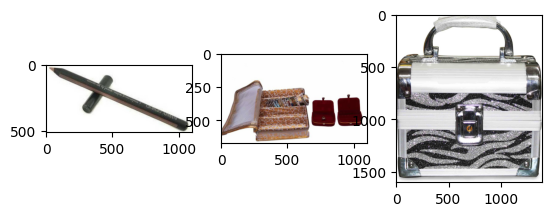

Computers


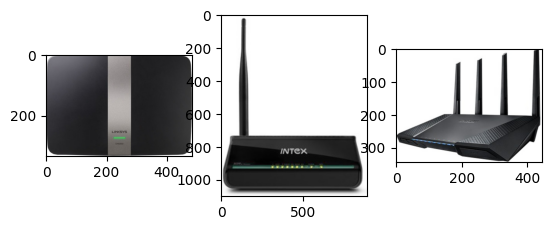

In [7]:
from matplotlib.image import imread
import cv2


list_labels = ['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers']
label_no_name = "no_name "

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name


list_furnishing=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Furnishing"]
list_baby=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Baby"]
list_watches=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Watches"]
list_decor=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Decor"]
list_kitchen=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Kitchen"]
list_beauty=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Beauty"]
list_computers=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Computers"]


for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [6]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [12]:
# identification of key points and associated descriptors
import time, cv2

images_features = []


temps1=time.time()


i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    #image = np.expand_dims(image, axis=0)
    #reduction bruit
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    #image = np.expand_dims(image, axis=0)

    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

In [13]:
image_features_all    = np.concatenate(images_features, axis=0)

print("Nombre de descripteurs VGG : ", image_features_all.shape)

duration1=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration1, "secondes")

Nombre de descripteurs VGG :  (4300800,)
temps de traitement VGG descriptor :           715.99 secondes


## Réduction dimension et analyse

### Réduction de dimension PCA

In [14]:
from sklearn import manifold, decomposition
print("Dimensions avant  réduction PCA : " ,images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print("Dimensions après réduction PCA : ", feat_pca.shape)

Dimensions avant  réduction PCA :  (1050, 4096)
Dimensions après réduction PCA :  (1050, 793)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [15]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             8.83 secondes


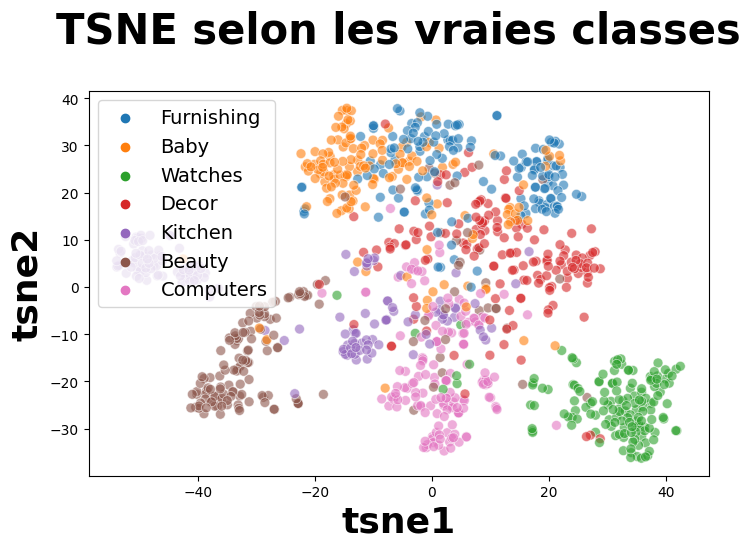

In [16]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [17]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

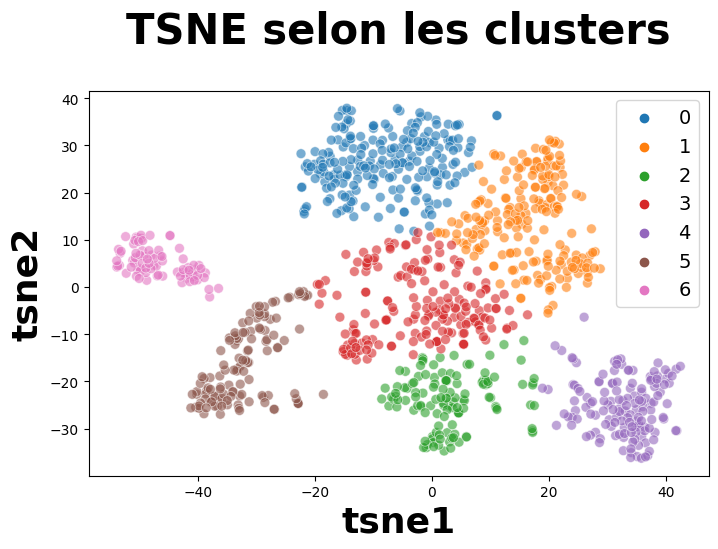

ARI :  0.46111327817834846


In [18]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [19]:
df_tsne

tsne1      tsne2       class  cluster
0     18.315262  18.286795  Furnishing        1
1      0.692546  35.399895        Baby        0
2     -4.305385  30.654255        Baby        0
3     15.453763  28.166103  Furnishing        1
4     15.272444  25.341940  Furnishing        1
...         ...        ...         ...      ...
1045  14.897941  16.878086        Baby        1
1046  13.440177  13.835081        Baby        1
1047  16.390419  14.079751        Baby        1
1048  13.060067  13.224270        Baby        1
1049   5.873064  -4.209337        Baby        3

[1050 rows x 4 columns]

In [20]:
# Analyse d'image affectées au cluster 3 

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Baby') and (df_tsne.iloc[i]['cluster']==3)]
list_shine_0[0]

106

tsne1        0.90928
tsne2      17.614838
class           Baby
cluster            0
Name: 220, dtype: object


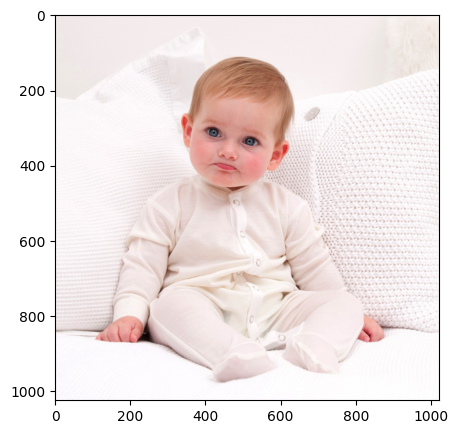

In [22]:

# Affichage image considéré comme baby

from matplotlib.image import imread
id = 220
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()



* Analyse : le modèle pré-entraîné confond baby et l'attribue au cluster 0,1 et 3. 

### Analyse par classes

In [23]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[113  19   2  12   1   2   1]
 [  6   7   5  16   1 115   0]
 [  1   0  98  50   1   0   0]
 [ 13 101   5  27   4   0   0]
 [ 77  67   0   6   0   0   0]
 [  1   2   0  65   0   4  78]
 [  0   0  12   3 135   0   0]]


In [23]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [29]:
import warnings
warnings.filterwarnings('ignore')
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 3 2 5 6 1 5]
[[113   2   2  19   0  13   1]
 [  6 115   5   7   0  16   1]
 [  1   0  98   0   0  50   1]
 [ 13   0   5 101   0  27   4]
 [ 77   0   0  67   0   6   0]
 [  1   4   0   2   0 143   0]
 [  0   0  12   0   0   3 135]]

              precision    recall  f1-score   support

           0       0.54      0.75      0.63       150
           1       0.95      0.77      0.85       150
           2       0.80      0.65      0.72       150
           3       0.52      0.67      0.58       150
           4       0.00      0.00      0.00       150
           5       0.55      0.95      0.70       150
           6       0.95      0.90      0.92       150

    accuracy                           0.67      1050
   macro avg       0.62      0.67      0.63      1050
weighted avg       0.62      0.67      0.63      1050



In [30]:
list_labels=['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers']

<Axes: >

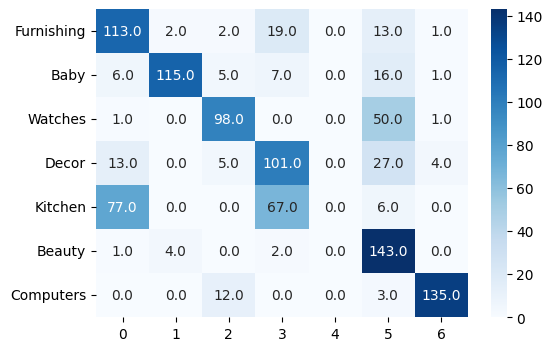

In [32]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",fmt=".1f")

Il y a des classes qui sont confondues alors que certaines sont bien classifiées. 

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [2]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [35]:
# Préparation des fichiers train et test 
train, test = train_test_split(data.sample(100, random_state=42), test_size = 0.25, random_state=42)
train, test = train_test_split(data, test_size = 0.25, random_state=42)

In [36]:
train.to_csv('data_saved_train.csv')
test.to_csv('data_saved_test.csv')

In [15]:
data_train=pd.read_csv("data_saved_train.csv")
data_test=pd.read_csv("data_saved_test.csv")
train_data=data_train.copy()
test_data=data_test.copy()

In [39]:
train_data.shape

(787, 5)

In [40]:
test_data.shape

(263, 5)

In [16]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(train_data)
print(images_np.shape)
images_np_test = image_prep_fct(test_data)
print(images_np_test.shape)

(787, 224, 224, 3)


C:\Users\kherm\anaconda\envs\Notebook_text\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(263, 224, 224, 3)


In [17]:
X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(590, 224, 224, 3)

In [47]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [48]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
import time
duration1=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration1, "secondes")

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 6.8438 - accuracy: 0.3661 
Epoch 1: val_loss improved from inf to 2.26787, saving model to .\model1_best_weights.h5
10/10 [==============================] - 167s 17s/step - loss: 6.8438 - accuracy: 0.3661 - val_loss: 2.2679 - val_accuracy: 0.6701
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.4343 - accuracy: 0.6559 
Epoch 2: val_loss improved from 2.26787 to 1.58049, saving model to .\model1_best_weights.h5
10/10 [==============================] - 176s 18s/step - loss: 2.4343 - accuracy: 0.6559 - val_loss: 1.5805 - val_accuracy: 0.7462
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.4354 - accuracy: 0.7356 
Epoch 3: val_loss did not improve from 1.58049
10/10 [==============================] - 174s 18s/step - loss: 1.4354 - accuracy: 0.7356 - val_loss: 1.5970 - val_accuracy: 0.7716
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.0845 - accuracy: 0.7729

In [52]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

19/19 [==============================] - 137s 7s/step - loss: 0.0091 - accuracy: 0.9966
Training Accuracy: 0.9966

7/7 [==============================] - 45s 6s/step - loss: 1.2504 - accuracy: 0.8122
Validation Accuracy:  0.8122


In [53]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8173
Test Accuracy       :  0.8175


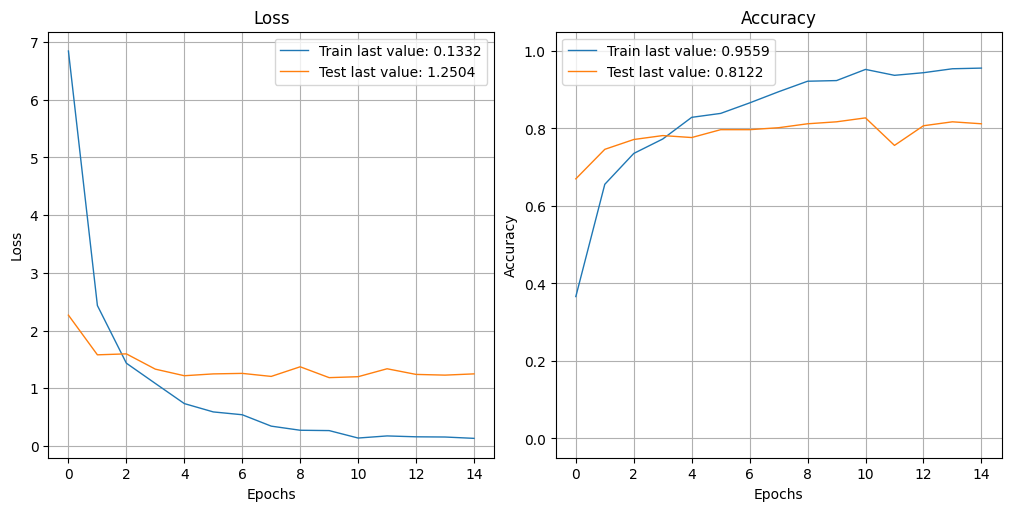

In [54]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [55]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 41s 6s/step
[2 3 4 5 4 6 0 0 1 5 3 2 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 1 4 2 5 4 0 1 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 3 4 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 0 6 4
 4 4 1 5 0 5 4 0 5 5 3 6 6 0 3 3 2 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 1 3 5 3 5 5 0 2 1 0 5 6]

[2 5 4 5 4 6 2 4 2 5 2 2 6 4 5 1 4 3 6 6 5 4 0 0 1 6 6 4 1 6 3 6 1 5 1 1 5
 5 4 6 0 5 1 4 3 5 2 1 3 4 2 3 6 4 2 5 4 0 1 0 1 1 4 6 6 0 1 2 0 2 0 0 0 5
 5 2 2 2 1 0 5 0 3 3 4 2 2 0 2 6 1 2 6 6 2 2 1 0 0 5 5 6 1 5 4 2 6 5 6 1 3
 3 2 6 2 4 2 3 3 4 3 3 1 2 4 5 2 6 6 2 0 6 3 1 6 6 5 0 6 0 0 5 0 1 1 4 6 4
 4 3 1 5 3 5 4 0 5 5 3 6 6 2 3 2 2 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 2 5 4 1
 3 3 3 3 5 5 0 2 1 0 3 6]


In [56]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[20  1  2  1  3  1  0]
 [ 0 24  2  2  1  1  1]
 [ 0  1 23  0  0  0  2]
 [ 3  0  4 18  0  3  0]
 [ 2  0  0  2 22  0  0]
 [ 1  0  1  2  0 26  0]
 [ 0  0  0  0  0  0 28]]


In [57]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[20  1  2  1  3  1  0]
 [ 0 24  2  2  1  1  1]
 [ 0  1 23  0  0  0  2]
 [ 3  0  4 18  0  3  0]
 [ 2  0  0  2 22  0  0]
 [ 1  0  1  2  0 26  0]
 [ 0  0  0  0  0  0 28]]

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.92      0.77      0.84        31
           2       0.72      0.88      0.79        26
           3       0.72      0.64      0.68        28
           4       0.85      0.85      0.85        26
           5       0.84      0.87      0.85        30
           6       0.90      1.00      0.95        28

    accuracy                           0.82       197
   macro avg       0.82      0.82      0.81       197
weighted avg       0.82      0.82      0.82       197



<Axes: >

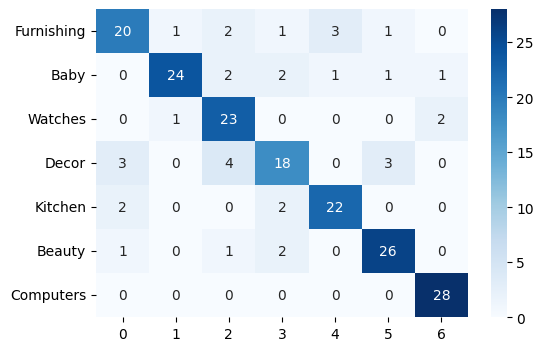

In [58]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images sont relativement bien classifiés avec un F1 score de 0.82 et accuracy de 0.81. 

# Data Augmentation 

In [81]:
df.head()

id   
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                          image_path  label_name  label  
0  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
1  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
2  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
3  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
4  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [61]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [72]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:


Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 263 validated image filenames belonging to 7 classes.


In [64]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [65]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [66]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
duration2=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration2, "secondes")

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 3.8224 - accuracy: 0.4708
Epoch 1: val_loss improved from inf to 1.09229, saving model to .\model2_best_weights.h5
25/25 [==============================] - 325s 13s/step - loss: 3.8224 - accuracy: 0.4708 - val_loss: 1.0923 - val_accuracy: 0.7366
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4854 - accuracy: 0.6954
Epoch 2: val_loss improved from 1.09229 to 0.93866, saving model to .\model2_best_weights.h5
25/25 [==============================] - 314s 13s/step - loss: 1.4854 - accuracy: 0.6954 - val_loss: 0.9387 - val_accuracy: 0.7710
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.7462 
Epoch 3: val_loss improved from 0.93866 to 0.90586, saving model to .\model2_best_weights.h5
25/25 [==============================] - 344s 14s/step - loss: 0.8791 - accuracy: 0.7462 - val_loss: 0.9059 - val_accuracy: 0.8053
Epoch 4/50
25/25 [==============================]

In [67]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 251s 10s/step - loss: 0.0741 - accuracy: 0.9772
Training Accuracy   : 0.9772

9/9 [==============================] - 80s 9s/step - loss: 0.8784 - accuracy: 0.8282
Validation Accuracy :  0.8282


In [68]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8130
Test Accuracy       :  0.8479


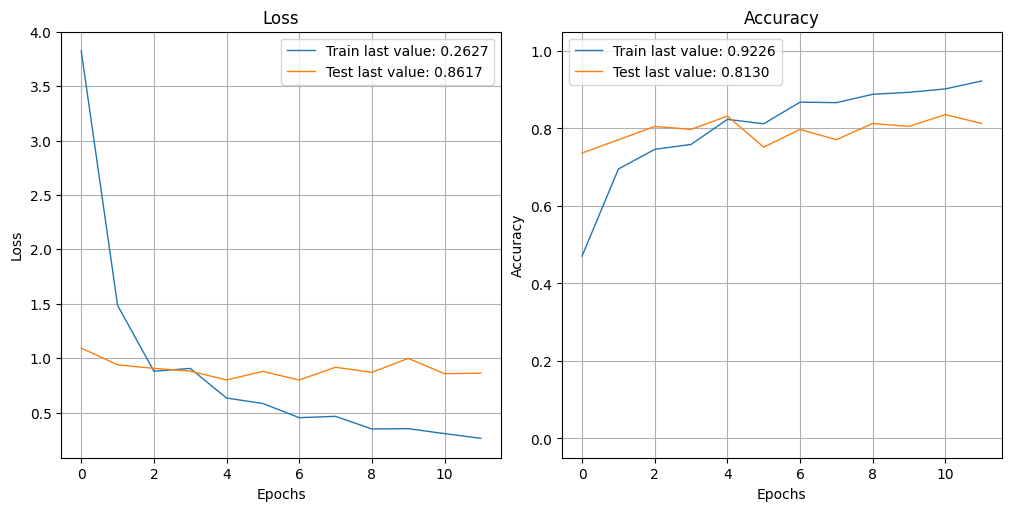

In [69]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [73]:
y_val_num2 = np.argmax(y_val, axis=1)
y_val_pred2 = np.argmax(model2.predict(X_val), axis=1)
y_val_num2 = np.argmax(y_val, axis=1)
print(y_val_num2)
print()
print(y_val_pred2)

7/7 [==============================] - 42s 6s/step
[2 3 4 5 4 6 0 0 1 5 3 2 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 1 4 2 5 4 0 1 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 3 4 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 0 6 4
 4 4 1 5 0 5 4 0 5 5 3 6 6 0 3 3 2 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 1 3 5 3 5 5 0 2 1 0 5 6]

[2 3 4 5 4 6 1 0 1 5 3 3 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 3 6 1 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 5 4 1 5 4 0 1 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 1 1 0 5 4 3 3 4 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 6 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 4 6 4
 4 4 1 5 0 5 4 0 5 5 3 6 6 0 3 3 5 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 1 3 5 3 5 5 0 2 1 0 5 6]


In [74]:
conf_mat = metrics.confusion_matrix(y_val_num2, y_val_pred2)
print(conf_mat)

[[25  2  0  0  1  0  0]
 [ 0 29  0  1  0  1  0]
 [ 0  2 21  1  0  1  1]
 [ 0  0  0 28  0  0  0]
 [ 0  0  0  0 26  0  0]
 [ 0  0  0  0  1 29  0]
 [ 0  0  0  0  0  0 28]]


In [75]:
y_val_pred_transform2 = conf_mat_transform(y_val_num2, y_val_pred2)
conf_mat = metrics.confusion_matrix(y_val_num2, y_val_pred_transform2)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num2, y_val_pred_transform2))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[25  2  0  0  1  0  0]
 [ 0 29  0  1  0  1  0]
 [ 0  2 21  1  0  1  1]
 [ 0  0  0 28  0  0  0]
 [ 0  0  0  0 26  0  0]
 [ 0  0  0  0  1 29  0]
 [ 0  0  0  0  0  0 28]]

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        28
           1       0.88      0.94      0.91        31
           2       1.00      0.81      0.89        26
           3       0.93      1.00      0.97        28
           4       0.93      1.00      0.96        26
           5       0.94      0.97      0.95        30
           6       0.97      1.00      0.98        28

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



<Axes: >

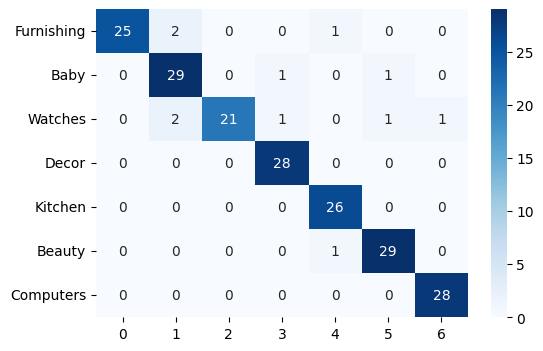

In [76]:
df_cm2 = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm2, annot=True, cmap="Blues")

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [3]:
batch_size = 32
path_original_dataset = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'

def dataset_fct(path, validation_split, data_type=None,label_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels=label_type, label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [4]:
path_train=r"C:\Users\kherm\Documents\Openclassrooms\projet 6\Flipkart\train"
path_test=r'C:\Users\kherm\Documents\Openclassrooms\projet 6\Flipkart\test'

dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training',label_type='inferred')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation',label_type='inferred')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None,label_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 1 classes.


In [5]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [7]:
from keras.utils.np_utils import to_categorical
import time

temps1=time.time()

with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)
    
duration3=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration3, "secondes")

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 6.8257 - accuracy: 0.4213
Epoch 1: val_loss improved from inf to 1.54859, saving model to .\model3_best_weights.h5
19/19 [==============================] - 176s 9s/step - loss: 6.8257 - accuracy: 0.4213 - val_loss: 1.5486 - val_accuracy: 0.7653
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 2.3185 - accuracy: 0.6785
Epoch 2: val_loss improved from 1.54859 to 1.31351, saving model to .\model3_best_weights.h5
19/19 [==============================] - 184s 10s/step - loss: 2.3185 - accuracy: 0.6785 - val_loss: 1.3135 - val_accuracy: 0.7704
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.8528 - accuracy: 0.7208
Epoch 3: val_loss improved from 1.31351 to 1.09446, saving model to .\model3_best_weights.h5
19/19 [==============================] - 185s 10s/step - loss: 1.8528 - accuracy: 0.7208 - val_loss: 1.0945 - val_accuracy: 0.7704
Epoch 4/50
19/19 [==============================] -

In [8]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 147s 8s/step - loss: 0.0180 - accuracy: 0.9949
Training Accuracy   : 0.9949

7/7 [==============================] - 46s 6s/step - loss: 1.1552 - accuracy: 0.8214
Validation Accuracy :  0.8214


In [9]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7959
Test Accuracy       :  0.0000


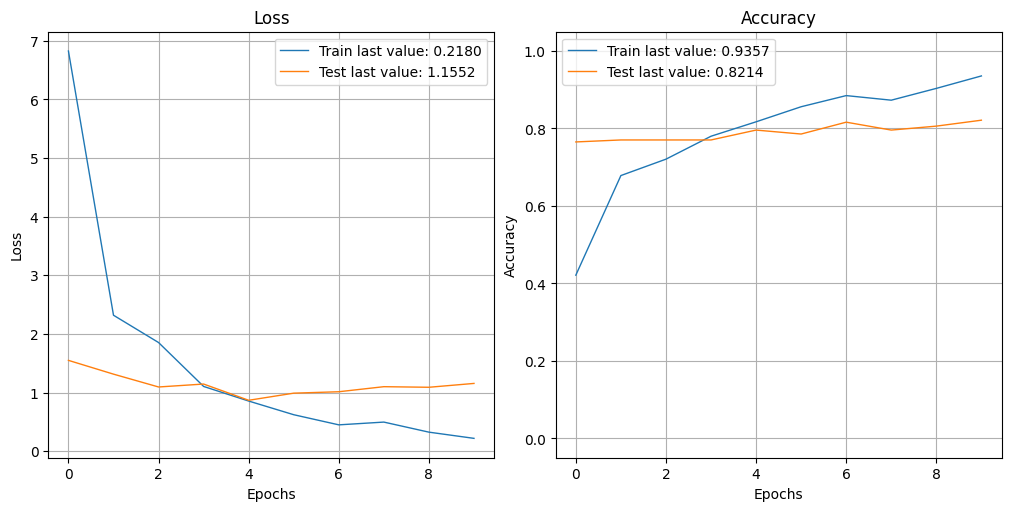

In [10]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [19]:
y_val_num3 = np.argmax(y_val, axis=1)
y_val_pred3 = np.argmax(model3.predict(X_val), axis=1)
y_val_num3 = np.argmax(y_val, axis=1)
print(y_val_num3)
print()
print(y_val_pred3)

7/7 [==============================] - 45s 6s/step
[2 3 4 5 4 6 0 0 1 5 3 2 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 1 4 2 5 4 0 1 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 3 4 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 0 6 4
 4 4 1 5 0 5 4 0 5 5 3 6 6 0 3 3 2 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 1 3 5 3 5 5 0 2 1 0 5 6]

[2 3 4 3 4 6 1 4 1 5 3 2 6 4 5 1 4 3 5 6 1 4 0 0 1 6 6 4 1 6 1 6 1 5 1 1 0
 3 4 6 0 5 1 4 3 6 2 1 4 4 2 3 1 1 1 5 4 0 1 0 1 1 4 6 6 4 1 2 0 3 0 0 0 5
 5 2 2 1 1 0 5 5 3 3 4 5 2 0 2 6 1 2 6 6 2 2 1 0 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 4 1 2 3 3 1 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 4 6 4
 4 1 1 5 3 5 4 4 5 5 3 6 1 0 1 0 5 5 0 6 5 3 4 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 3 3 5 3 5 5 0 2 1 0 3 6]


In [21]:
from sklearn import cluster, metrics
conf_mat = metrics.confusion_matrix(y_val_num3, y_val_pred3)
print(conf_mat)

[[20  2  0  1  5  0  0]
 [ 0 29  0  1  0  1  0]
 [ 0  2 22  0  0  2  0]
 [ 2  1  0 22  2  1  0]
 [ 0  3  0  0 23  0  0]
 [ 0  1  0  2  0 26  1]
 [ 0  1  0  0  0  0 27]]


In [24]:
y_val_pred_transform3 = conf_mat_transform(y_val_num3, y_val_pred3)
conf_mat = metrics.confusion_matrix(y_val_num3, y_val_pred_transform3)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num3, y_val_pred_transform3))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[20  2  0  1  5  0  0]
 [ 0 29  0  1  0  1  0]
 [ 0  2 22  0  0  2  0]
 [ 2  1  0 22  2  1  0]
 [ 0  3  0  0 23  0  0]
 [ 0  1  0  2  0 26  1]
 [ 0  1  0  0  0  0 27]]

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.74      0.94      0.83        31
           2       1.00      0.85      0.92        26
           3       0.85      0.79      0.81        28
           4       0.77      0.88      0.82        26
           5       0.87      0.87      0.87        30
           6       0.96      0.96      0.96        28

    accuracy                           0.86       197
   macro avg       0.87      0.86      0.86       197
weighted avg       0.87      0.86      0.86       197



<Axes: >

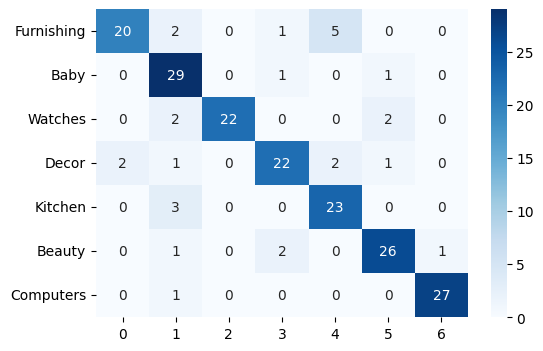

In [26]:
list_labels = ['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers']
df_cm3 = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm3, annot=True, cmap="Blues")

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [27]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None,label_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels=label_type, label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [28]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training',label_type='inferred')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation',label_type='inferred')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None,label_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 1 classes.


In [29]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

### Quelques Exemples d'illustration du data augmentation

https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/

Found 787 files belonging to 7 classes.
Using 630 files for training.


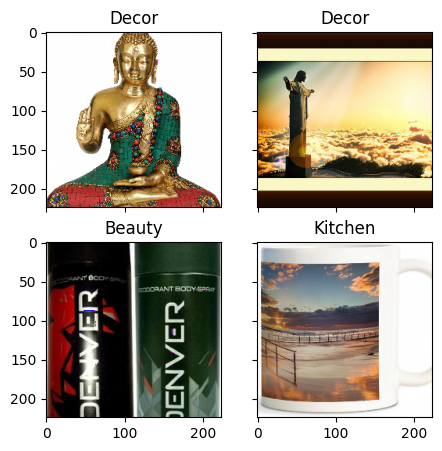

In [42]:
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# use image_dataset_from_directory() to load images, with image size scaled to 256x256
PATH=path_train  # modify to your path
ds = image_dataset_from_directory(PATH,
                                  validation_split=0.2, subset="training",
                                  image_size=(224,224), interpolation="mitchellcubic",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

# Take one batch from dataset and display the images
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5,5))

for images, labels in ds.take(1):
    for i in range(2):
        for j in range(2):
            ax[i][j].imshow(images[i*2+j].numpy().astype("uint8"))
            ax[i][j].set_title(ds.class_names[labels[i*2+j]])
plt.show()

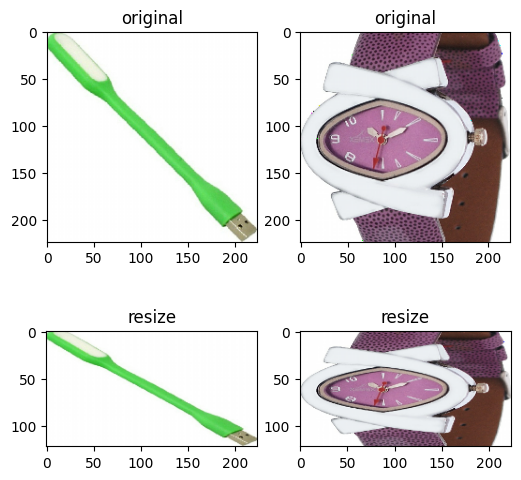

In [46]:
# create a resizing layer
out_height, out_width = 122,224
resize = tf.keras.layers.Resizing(out_height, out_width)
 
# show original vs resized
fig, ax = plt.subplots(2, 2, figsize=(6,6))
 
for images, labels in ds.take(1):
    for i in range(2):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # resize
        ax[1][i].imshow(resize(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("resize")
plt.show()

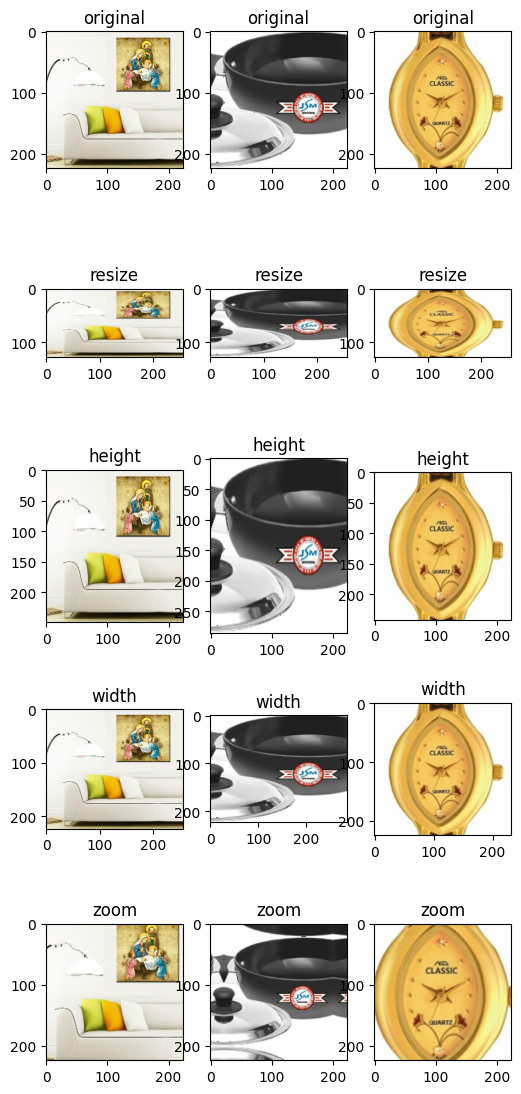

In [47]:

# Create preprocessing layers
out_height, out_width = 128,256
resize = tf.keras.layers.Resizing(out_height, out_width)
height = tf.keras.layers.RandomHeight(0.3)
width = tf.keras.layers.RandomWidth(0.3)
zoom = tf.keras.layers.RandomZoom(0.3)

# Visualize images and augmentations
fig, ax = plt.subplots(5, 3, figsize=(6,14))

for images, labels in ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # resize
        ax[1][i].imshow(resize(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("resize")
        # height
        ax[2][i].imshow(height(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("height")
        # width
        ax[3][i].imshow(width(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("width")
        # zoom
        ax[4][i].imshow(zoom(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("zoom")
plt.show()

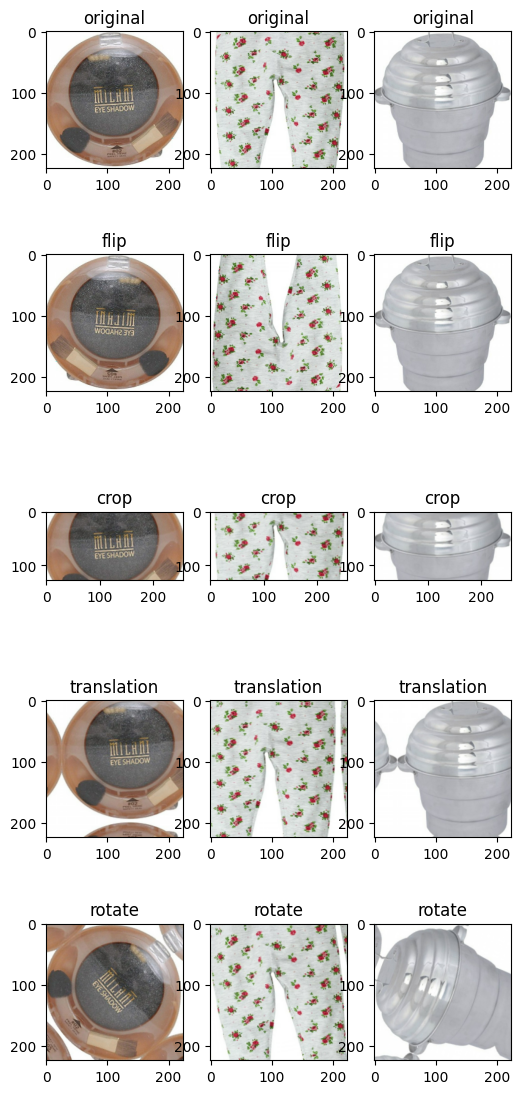

In [48]:
# Create preprocessing layers
flip = tf.keras.layers.RandomFlip("horizontal_and_vertical") # or "horizontal", "vertical"
rotate = tf.keras.layers.RandomRotation(0.2)
crop = tf.keras.layers.RandomCrop(out_height, out_width)
translation = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)

# Visualize augmentations
fig, ax = plt.subplots(5, 3, figsize=(6,14))

for images, labels in ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # flip
        ax[1][i].imshow(flip(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("flip")
        # crop
        ax[2][i].imshow(crop(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("crop")
        # translation
        ax[3][i].imshow(translation(images[i]).numpy().astype("uint8"))
        ax[3][i].set_title("translation")
        # rotate
        ax[4][i].imshow(rotate(images[i]).numpy().astype("uint8"))
        ax[4][i].set_title("rotate")
plt.show()

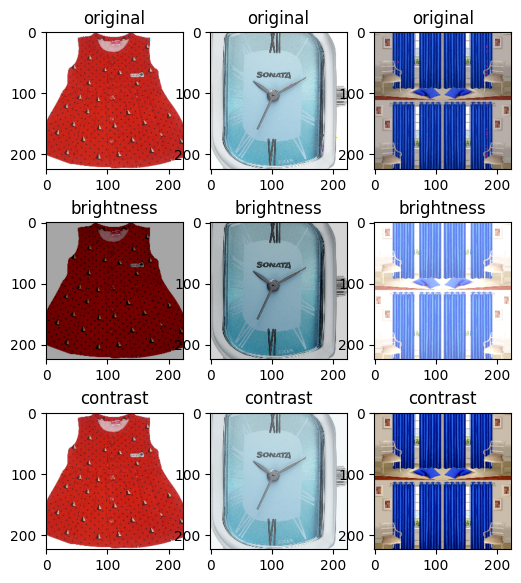

In [49]:

brightness = tf.keras.layers.RandomBrightness([-0.8,0.8])
contrast = tf.keras.layers.RandomContrast(0.2)

# Visualize augmentation
fig, ax = plt.subplots(3, 3, figsize=(6,7))

for images, labels in ds.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
        ax[0][i].set_title("original")
        # brightness
        ax[1][i].imshow(brightness(images[i]).numpy().astype("uint8"))
        ax[1][i].set_title("brightness")
        # contrast
        ax[2][i].imshow(contrast(images[i]).numpy().astype("uint8"))
        ax[2][i].set_title("contrast")
plt.show()

## Implémentation du modèle de data augmentation

In [54]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [55]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [56]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [57]:
temps1=time.time()


with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

duration4=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration4, "secondes")

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.9060 - accuracy: 0.2453
Epoch 1: val_loss improved from inf to 1.44569, saving model to .\model4_best_weights.h5
19/19 [==============================] - 183s 10s/step - loss: 1.9060 - accuracy: 0.2453 - val_loss: 1.4457 - val_accuracy: 0.6582
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 1.4628 - accuracy: 0.4873
Epoch 2: val_loss improved from 1.44569 to 1.13274, saving model to .\model4_best_weights.h5
19/19 [==============================] - 189s 10s/step - loss: 1.4628 - accuracy: 0.4873 - val_loss: 1.1327 - val_accuracy: 0.6939
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.2322 - accuracy: 0.6108
Epoch 3: val_loss improved from 1.13274 to 0.97385, saving model to .\model4_best_weights.h5
19/19 [==============================] - 187s 10s/step - loss: 1.2322 - accuracy: 0.6108 - val_loss: 0.9739 - val_accuracy: 0.7347
Epoch 4/50
19/19 [==============================] 

In [58]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 137s 7s/step - loss: 0.4227 - accuracy: 0.8663
Training Accuracy   : 0.8663

7/7 [==============================] - 47s 7s/step - loss: 0.6257 - accuracy: 0.8010
Validation Accuracy :  0.8010


In [59]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7959
Test Accuracy       :  0.0000


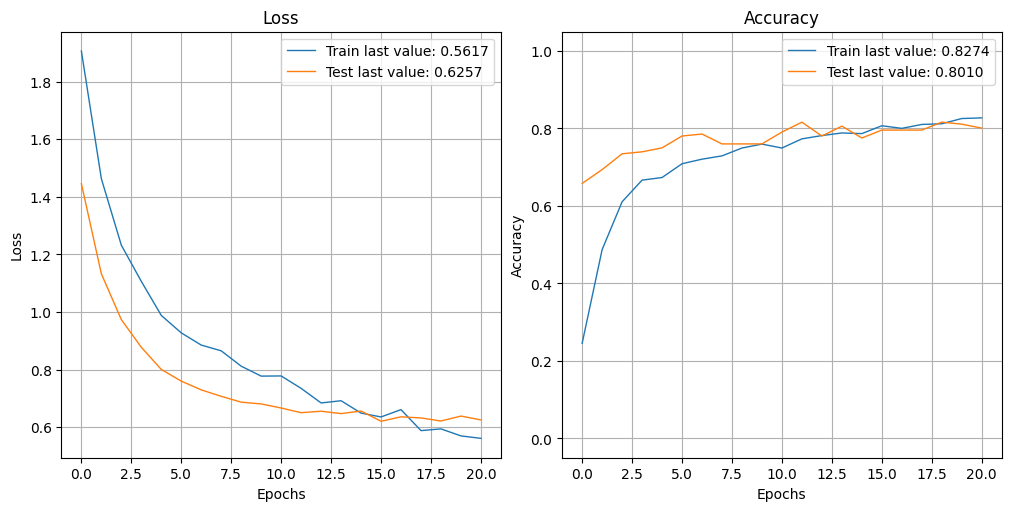

In [60]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [61]:
y_val_num4 = np.argmax(y_val, axis=1)
y_val_pred4 = np.argmax(model4.predict(X_val), axis=1)
y_val_num4 = np.argmax(y_val, axis=1)
print(y_val_num4)
print()
print(y_val_pred4)

7/7 [==============================] - 43s 6s/step
[2 3 4 5 4 6 0 0 1 5 3 2 6 4 3 1 0 3 2 6 5 4 0 0 1 6 6 4 1 6 1 6 0 5 1 1 0
 3 4 6 0 5 1 4 3 5 2 1 4 4 2 3 1 4 2 5 4 0 1 0 1 1 4 6 6 3 1 2 0 3 0 0 0 5
 5 2 2 2 1 0 5 5 3 3 4 1 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 2 1 3
 3 2 6 3 1 2 3 3 4 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 0 6 0 4 1 3 1 2 0 6 4
 4 4 1 5 0 5 4 0 5 5 3 6 6 0 3 3 2 5 0 6 5 3 0 4 2 6 0 4 1 3 4 1 5 5 5 4 1
 1 3 5 3 5 5 0 2 1 0 5 6]

[2 3 4 5 0 6 1 3 2 5 3 3 6 4 3 1 4 3 5 6 1 4 0 0 1 6 6 4 1 6 3 6 1 5 1 1 5
 3 4 6 0 5 1 4 3 3 2 1 4 4 3 3 2 4 1 5 0 0 1 0 1 1 4 6 6 3 1 2 0 3 0 5 4 2
 5 2 2 1 1 0 5 3 3 3 4 6 2 0 2 6 1 2 6 6 2 2 1 3 0 5 5 6 1 5 4 2 6 5 6 1 3
 3 2 6 1 3 2 3 3 0 3 3 1 2 4 5 2 6 6 2 4 6 3 1 6 6 5 4 6 0 4 1 5 1 2 4 6 4
 4 4 1 5 0 5 4 0 1 5 3 6 6 3 3 3 2 3 0 6 5 3 0 4 2 6 0 4 1 2 4 1 5 5 5 4 1
 3 3 5 3 3 5 0 2 1 0 5 6]


In [62]:
conf_mat = metrics.confusion_matrix(y_val_num4, y_val_pred4)
print(conf_mat)

[[18  2  0  2  4  2  0]
 [ 0 25  2  3  0  0  1]
 [ 0  2 20  2  0  1  1]
 [ 0  1  1 25  0  1  0]
 [ 3  0  0  0 23  0  0]
 [ 0  2  1  4  0 23  0]
 [ 0  0  0  0  0  0 28]]


In [63]:
y_val_pred_transform4 = conf_mat_transform(y_val_num4, y_val_pred4)
conf_mat = metrics.confusion_matrix(y_val_num4, y_val_pred_transform4)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num4, y_val_pred_transform4))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[18  2  0  2  4  2  0]
 [ 0 25  2  3  0  0  1]
 [ 0  2 20  2  0  1  1]
 [ 0  1  1 25  0  1  0]
 [ 3  0  0  0 23  0  0]
 [ 0  2  1  4  0 23  0]
 [ 0  0  0  0  0  0 28]]

              precision    recall  f1-score   support

           0       0.86      0.64      0.73        28
           1       0.78      0.81      0.79        31
           2       0.83      0.77      0.80        26
           3       0.69      0.89      0.78        28
           4       0.85      0.88      0.87        26
           5       0.85      0.77      0.81        30
           6       0.93      1.00      0.97        28

    accuracy                           0.82       197
   macro avg       0.83      0.82      0.82       197
weighted avg       0.83      0.82      0.82       197



<Axes: >

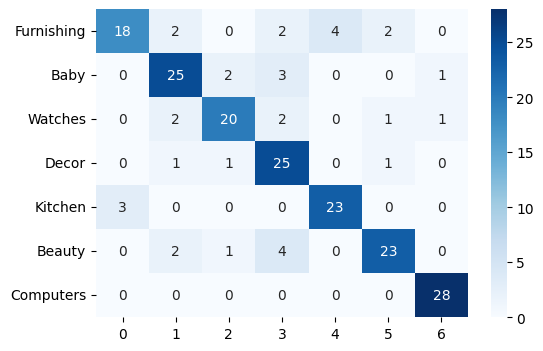

In [64]:
list_labels = ['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers']
df_cm4 = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm4, annot=True, cmap="Blues")